In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from utils.util import *
from utils.model import *
from utils.train import *
from utils.dataset import *
# from utils.dataset_imgNet import *
# from utils.dataset_imgNet import *

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [22]:
# loaded = torch.load('/home/hongrok/ATE/hongrok/IMNN_cifar10_2class_0713_dog/results_dog2/ret_class2__1.7__0.5_7_0.3.pt')
# loaded = torch.load('/home/hongrok/ATE/hongrok/IMNN_cifar10_2class_0713_dog/results_dog2/ret_class2__1.7__0.5_7_0.pt')


# loaded = torch.load('/home/hongrok/ATE/hongrok/IMNN_cifar10_2class_0713_dog/results_dog2/ret_class2__2__4_200_0.14.pt')


# loaded = torch.load('/home/hongrok/ATE/hongrok/IMNN_cifar10_2class_0713_dog/results_dog2/ret_class2__2__0.3_22_0.pt')
# loaded = torch.load('/home/hongrok/ATE/hongrok/IMNN_cifar10_2class_0713_dog/results_dog2/ret_class2__2__0.3_22_0.14.pt')

In [158]:
path = '/home/hongrok/ATE/hongrok/IMNN_cifar10_2class_0713_dog/results/ret_class2__2__4_200_0.14.pt'
path = f'/home/hongrok/ATE/hongrok/IMNN_cifar10_2class_0801_cifar/results_tau/ret_class2__2__4_200_0.0_tau{tau}.pt'
loaded = torch.load(path)
outcome = loaded['model']['outcome']

In [161]:
loaded['class_dist']-5000

0   -4428
1   -4908
Name: count, dtype: int64

In [138]:
dummy = torch.ones(1, 3, 32, 32, device=device)
outcome.eval()
with torch.no_grad():
    print(outcome(dummy))

tensor([[ 0.9023, -1.7328]], device='cuda:0')


In [5]:
def ECE(path):
    loaded = torch.load(path)
    if 'tau' in path:
        tau = float(path.split('tau')[-1].split('.pt')[0])
    else:
        alpha = float(path.split('_')[-1].split('.pt')[0])
        tau = 1
    outcome = loaded['model']['outcome']
    # print(loaded['params']['alpha'], loaded['params']['label_weight'], loaded['params']['model_seed'],)
    model_seed = loaded['params']['model_seed']
    fix_seed(model_seed, deterministic=True)
    data_dict = load_cifar10()
    print(data_dict['label_names'])
    data_dict = cut_class(data_dict, remain = ['bird', 'deer'])
    split_obs_mis_with_lr(data_dict, loaded['params']['label_weight'], seed=100)
    class_dist = pd.Series(data_dict['train_obs_labels']).value_counts().sort_index()
    # print(class_dist)

    # dataset
    dataset_obs = Dataset(data_dict, mode='train_obs', use_transform=False)
    # print(dataset_obs[0][0].shape)
    dataset_mis = Dataset(data_dict, mode='train_mis', use_transform=True)
    # dataset_mis_none = Dataset(data_dict, mode='train_mis', use_transform=False)
    dataset_obs_train, dataset_obs_val = torch.utils.data.random_split(dataset_obs, (0.7, 0.3))
    # dataset_mis_train, dataset_mis_val = torch.utils.data.random_split(dataset_mis, (0.7, 0.3))

    subset_obs_train_aug = Subset(dataset_obs_train, use_transform=True)
    subset_obs_train_norm = Subset(dataset_obs_train, use_transform=False)
    subset_obs_val_norm = Subset(dataset_obs_val, use_transform=False)

    alpha = loaded['params']['alpha']
    dataset = dataset_mis
    dataset = subset_obs_val_norm
    plt.figure(figsize=(17, 4))
    data_label = ['labeled', 'labeled_val', 'unlabeled']
    eces = []
    for l, dataset in enumerate([subset_obs_train_norm, subset_obs_val_norm, dataset_mis]):
        plt.subplot(1, 3, l+1)
        criterion = torch.nn.CrossEntropyLoss(label_smoothing=alpha).to(device)
        preds = evaluate(outcome, dataset, device, criterion, tau=tau, take_out=True)
        # print(preds.sum())
        y_true = np.array(dataset.y)
        preds = softmax(preds)

        # binary에서 confidence를 max에서 가져올지 그냥 p(1)에서 가져올지?

        # binary
        conf = preds[:, 1]
        y_pred = torch.max(preds, dim=1)[1]

        # # multi-class
        conf, y_pred = torch.max(preds, dim=1)
        acc = np.mean(y_true == y_pred.numpy())
        # print('전체 acc: ', acc)

        # print(y_true.shape, y_pred.numpy().shape)

        M = 20
        bins = torch.linspace(0, 1, M + 1)

        xi_lst = []
        conf_lst = []
        acc_lst = []
        ece_lst = []
        gap_lst = []
        cnt_lst = []
        for i in range(M):
            check = conf.gt(bins[i]) * conf.le(bins[i+1])
            cnt_lst.append(sum(check).item())
            bin_prob = check.float().mean()
            # print(sum(check))
            if bin_prob > 0:
                conf_bin = conf[check].mean()
                acc_bin = (y_true==y_pred.numpy())[check].mean()
                gap = abs(conf_bin.item() - acc_bin)
                
                # print(conf_bin.item(), acc_bin, f'{sum(check)}({bin_prob.item()})')
                conf_lst.append(conf_bin.item())
                acc_lst.append(acc_bin.item())
                gap_lst.append(gap)
                ece_lst.append(gap * bin_prob.item())
                xi_lst.append(i)
        ece = sum(ece_lst)
        eces.append(ece)
        ###############################################################################
        # xs = [x + 0.5 for x in range(M)]
        xs = np.array([x + 1/M/2 for x in bins.numpy()[:-1]])[xi_lst]
        width = 1/M
        for x, cnt in zip(np.array([x + 1/M/2 for x in bins.numpy()[:-1]]), cnt_lst):
            plt.text(x, 0.2, cnt, ha='center', color='blue', size=8)
        plt.bar(xs, gap_lst, bottom=np.minimum(conf_lst, acc_lst), label='Gap', color='red', alpha=0.4, width=width, hatch='/',
                edgecolor='black')
        # plt.bar(xs, acc_lst, label='Accuracy', color='red', width=width, alpha=0.4, hatch='/',
        #         edgecolor='black')
        plt.bar(xs, acc_lst, label='Output', color='navy', width=width, alpha=0.4, 
                edgecolor='black')
        plt.plot([0, 1], [0, 1], color='gray', alpha=0.7, ls=':')

        conf_mean = conf.mean().item()
        acc_all = np.mean(y_true==y_pred.numpy())
        plt.vlines(conf_mean, 0, 1, color='black', ls='--')
        plt.text(conf_mean, 0.7, 'Avg. confidence', rotation=90, ha='right')

        plt.vlines(acc_all, 0, 1, color='black', ls='--')
        plt.text(acc_all, 0.7, 'Accuracy', rotation=90, ha='left')

        plt.xticks(bins.numpy(), bins.numpy().round(2), rotation=70)
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.ylabel('Accuracy', size=12)
        plt.xlabel('Confidence', size=12)
        plt.legend()
        plt.title(f'[{data_label[l]}]ECE: {round(ece, 5)}, alpha: {alpha}, tau:{tau}\nacc:{round(acc, 4)}, confidence:{round(conf_mean, 4)}')
        plt.xlim(0, 1)
        plt.grid(alpha=0.4, ls=':')
    plt.show()
    return eces

In [18]:
def get_conf(path):
    loaded = torch.load(path)
    if 'tau' in path:
        tau = float(path.split('tau')[-1].split('.pt')[0])
    else:
        alpha = float(path.split('_')[-1].split('.pt')[0])
        tau = 1
    outcome = loaded['model']['outcome']
    # print(loaded['params']['alpha'], loaded['params']['label_weight'], loaded['params']['model_seed'],)
    model_seed = loaded['params']['model_seed']
    fix_seed(model_seed, deterministic=True)
    data_dict = load_cifar10()
    print(data_dict['label_names'])
    data_dict = cut_class(data_dict, remain = ['bird', 'deer'])
    split_obs_mis_with_lr(data_dict, loaded['params']['label_weight'], seed=100)
    class_dist = pd.Series(data_dict['train_obs_labels']).value_counts().sort_index()
    # print(class_dist)

    # dataset
    dataset_obs = Dataset(data_dict, mode='train_obs', use_transform=False)
    # print(dataset_obs[0][0].shape)
    dataset_mis = Dataset(data_dict, mode='train_mis', use_transform=True)
    # dataset_mis_none = Dataset(data_dict, mode='train_mis', use_transform=False)
    dataset_obs_train, dataset_obs_val = torch.utils.data.random_split(dataset_obs, (0.7, 0.3))
    # dataset_mis_train, dataset_mis_val = torch.utils.data.random_split(dataset_mis, (0.7, 0.3))

    subset_obs_train_aug = Subset(dataset_obs_train, use_transform=True)
    subset_obs_train_norm = Subset(dataset_obs_train, use_transform=False)
    subset_obs_val_norm = Subset(dataset_obs_val, use_transform=False)

    alpha = loaded['params']['alpha']
    dataset = dataset_mis
    dataset = subset_obs_val_norm
    data_label = ['labeled', 'labeled_val', 'unlabeled']
    eces = []
    preds = []
    for l, dataset in enumerate([subset_obs_train_norm, subset_obs_val_norm, dataset_mis]):
        criterion = torch.nn.CrossEntropyLoss(label_smoothing=alpha).to(device)
        pred = evaluate(outcome, dataset, device, criterion, tau=tau, take_out=True)
        preds.append(softmax(pred))
        
    return preds


preds = get_conf(f'/home/hongrok/ATE/hongrok/IMNN_cifar10_2class_0808_alexnet/results_alex/ret_class2__2__4_2000_{alpha}_tau{tau}.pt')

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


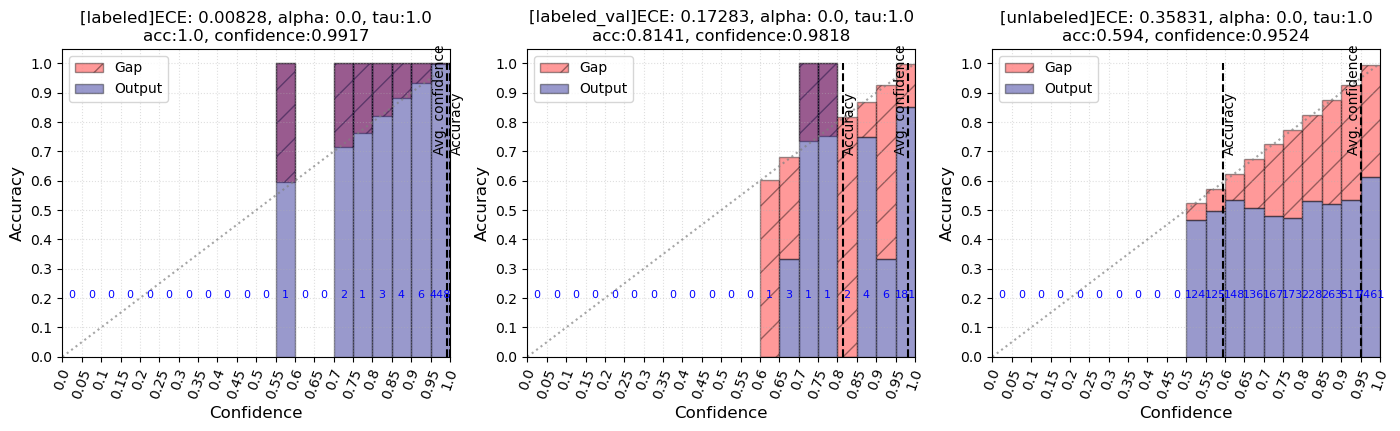

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


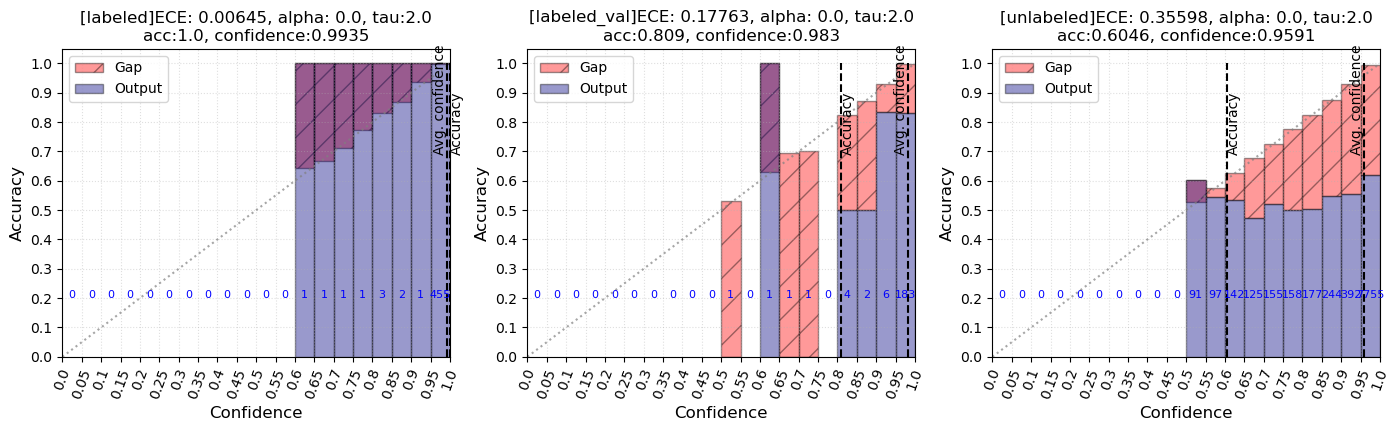

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


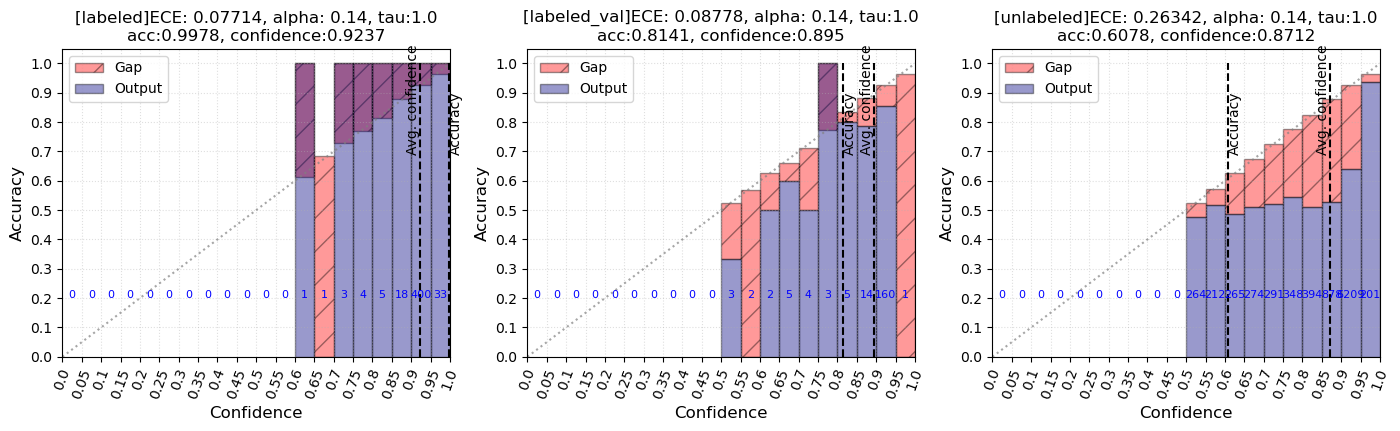

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


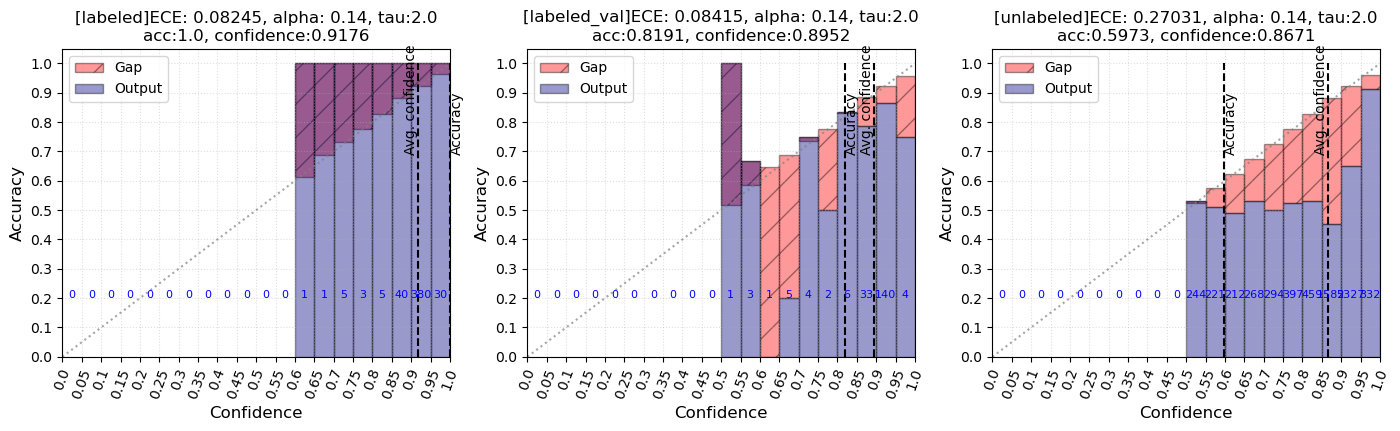

In [6]:
alphas = [0.0, 0.14]
taus = [1, 2]
eces_obs = []
eces_obs_val = []
eces_mis = []
for alpha in alphas:
    for tau in taus:
        ece_obs, ece_obs_val, ece_mis = ECE(f'/home/hongrok/ATE/hongrok/IMNN_cifar10_2class_0808_alexnet/results_alex/ret_class2__2__4_200_{alpha}_tau{tau}.pt')
        eces_obs.append(ece_obs)
        eces_obs_val.append(ece_obs_val)
        eces_mis.append(ece_mis)
        # print(f'/home/hongrok/ATE/hongrok/IMNN_cifar10_2class_0801_cifar/results_tau/ret_class2__2__4_200_0.0_tau{tau}.pt')

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


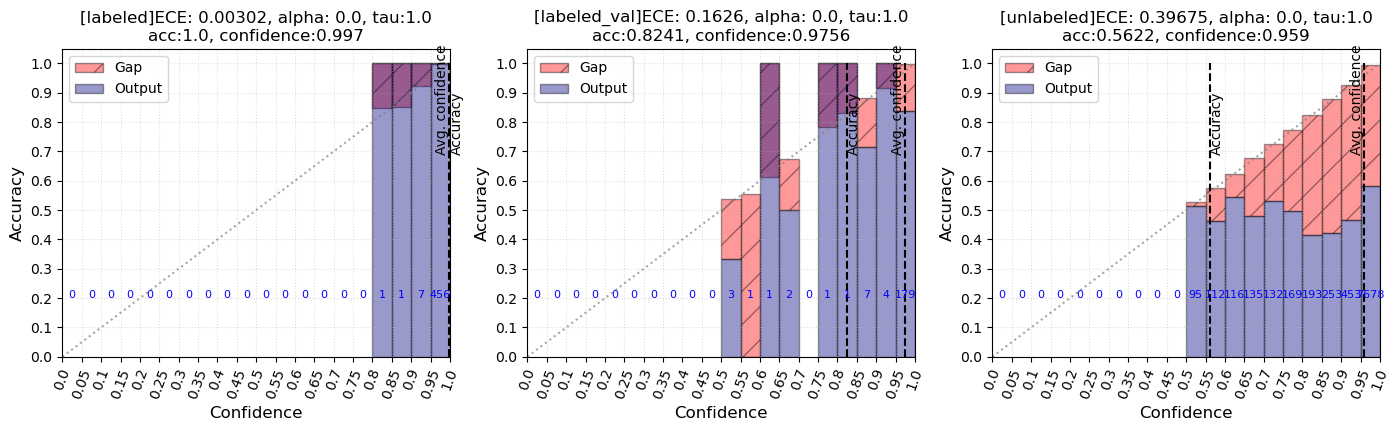

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


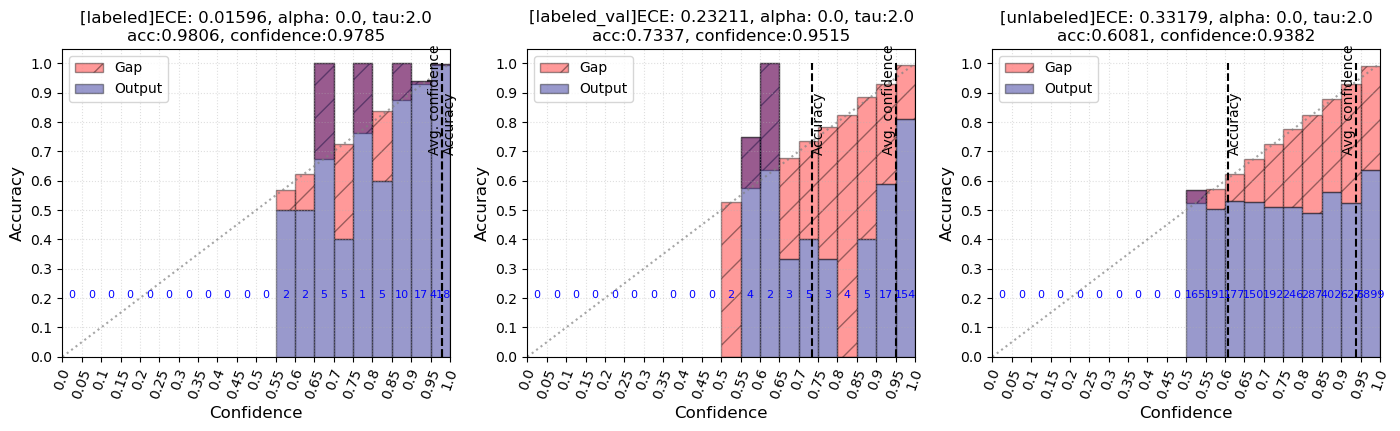

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


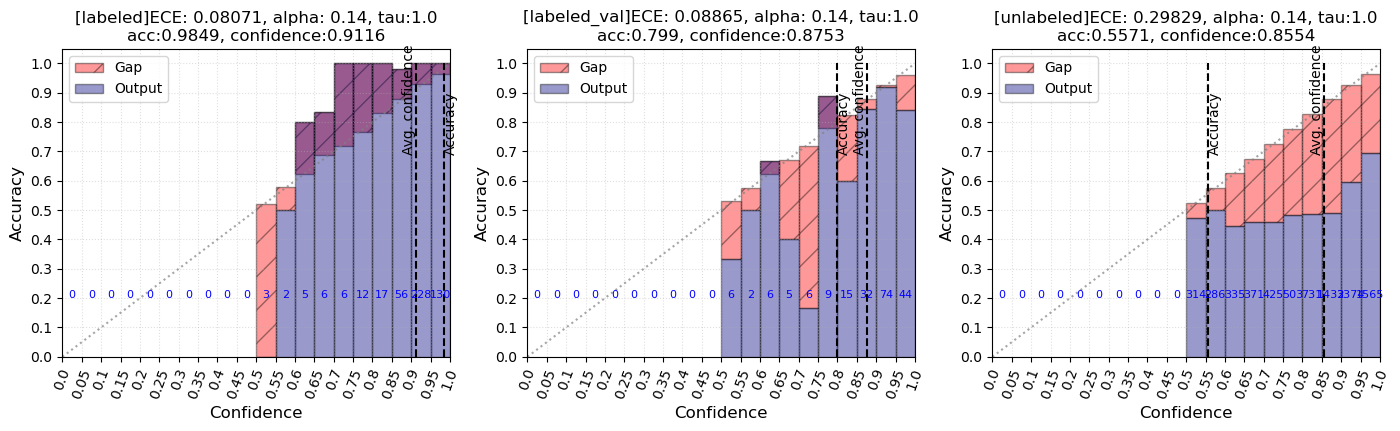

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


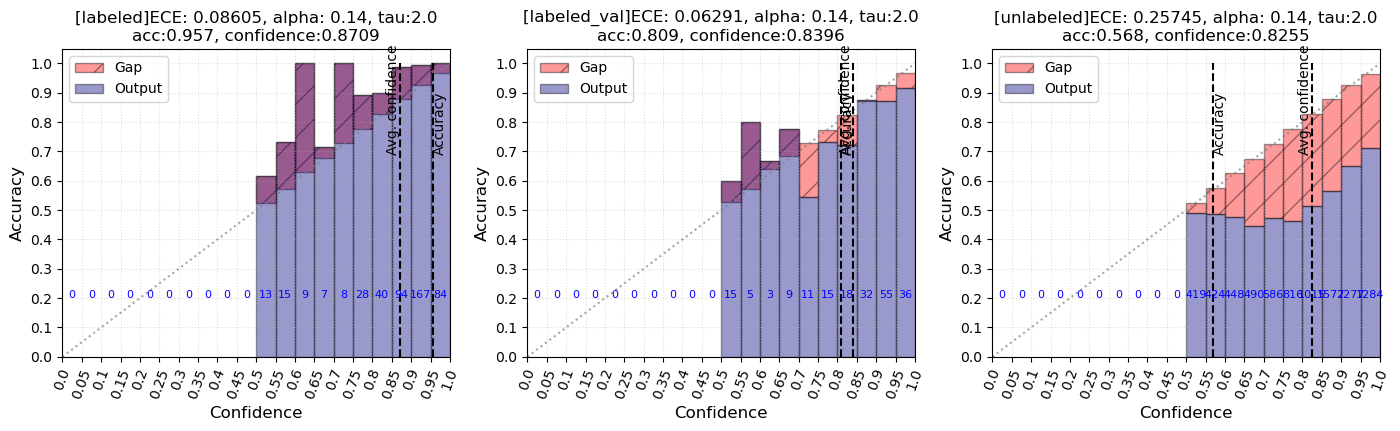

In [7]:
alphas = [0.0, 0.14]
taus = [1, 2]
eces_obs = []
eces_obs_val = []
eces_mis = []
for alpha in alphas:
    for tau in taus:
        ece_obs, ece_obs_val, ece_mis = ECE(f'/home/hongrok/ATE/hongrok/IMNN_cifar10_2class_0808_alexnet/results_resnet/ret_class2__2__4_200_{alpha}_tau{tau}.pt')
        eces_obs.append(ece_obs)
        eces_obs_val.append(ece_obs_val)
        eces_mis.append(ece_mis)
        # print(f'/home/hongrok/ATE/hongrok/IMNN_cifar10_2class_0801_cifar/results_tau/ret_class2__2__4_200_0.0_tau{tau}.pt')

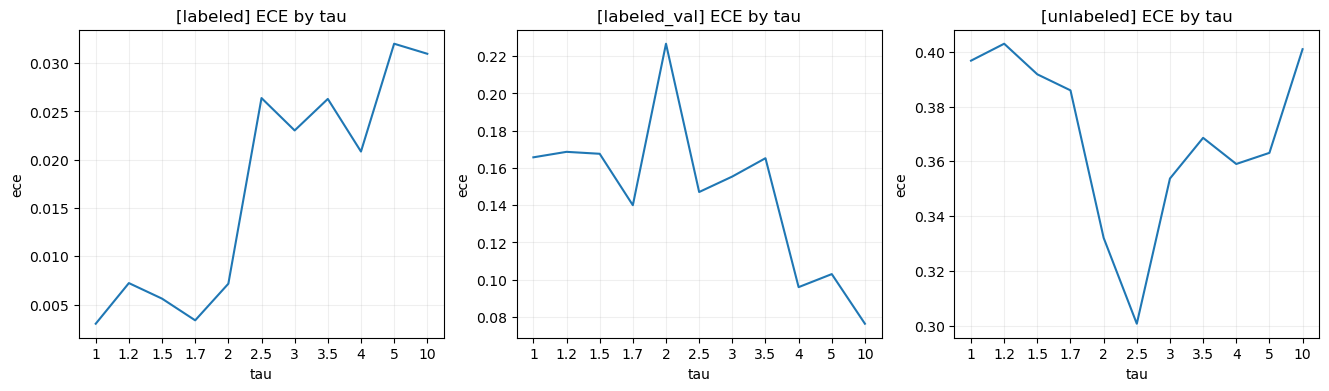

In [168]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(eces_obs)
plt.xticks(range(len(eces_obs)), taus)
plt.xlabel('tau')
plt.ylabel('ece')
plt.title('[labeled] ECE by tau', size=12)
plt.grid(alpha=0.2)

plt.subplot(1, 3, 2)
plt.plot(eces_obs_val)
plt.xticks(range(len(eces_obs_val)), taus)
plt.xlabel('tau')
plt.ylabel('ece')
plt.title('[labeled_val] ECE by tau', size=12)
plt.grid(alpha=0.2)

plt.subplot(1, 3, 3)
plt.plot(eces_mis)
plt.xticks(range(len(eces_mis)), taus)
plt.xlabel('tau')
plt.ylabel('ece')
plt.title('[unlabeled] ECE by tau', size=12)
plt.grid(alpha=0.2)
plt.show()

In [ ]:
path = '/home/hongrok/ATE/hongrok/IMNN_cifar10_2class_0801_cifar/results_tau/ret_class2__2__4_200_0.0_tau0.3.pt'
loaded = torch.load(path)
tau = float(path.split('tau')[-1].split('.pt')[0])
outcome = loaded['model']['outcome']
print(loaded['params']['alpha'], loaded['params']['label_weight'], loaded['params']['model_seed'],)

data_dict = load_cifar10()
print(data_dict['label_names'])
data_dict = cut_class(data_dict, remain = ['bird', 'deer'])
split_obs_mis_with_lr(data_dict, loaded['params']['label_weight'], seed=100)
class_dist = pd.Series(data_dict['train_obs_labels']).value_counts().sort_index()
print(class_dist)

# dataset
dataset_obs = Dataset(data_dict, mode='train_obs', use_transform=False)
print(dataset_obs[0][0].shape)
dataset_mis = Dataset(data_dict, mode='train_mis', use_transform=True)
# dataset_mis_none = Dataset(data_dict, mode='train_mis', use_transform=False)
dataset_obs_train, dataset_obs_val = torch.utils.data.random_split(dataset_obs, (0.7, 0.3))
# dataset_mis_train, dataset_mis_val = torch.utils.data.random_split(dataset_mis, (0.7, 0.3))

subset_obs_train_aug = Subset(dataset_obs_train, use_transform=True)
subset_obs_train_norm = Subset(dataset_obs_train, use_transform=False)
subset_obs_val_norm = Subset(dataset_obs_val, use_transform=False)

alpha = loaded['params']['alpha']
dataset = dataset_mis
#     dataset = subset_obs_val_norm
criterion = torch.nn.CrossEntropyLoss(label_smoothing=alpha).to(device)
preds = evaluate(outcome, dataset, device, criterion, tau=tau, take_out=True)
y_true = np.array(dataset.y)
preds = softmax(preds)